In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
#@title Define Callback
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(AccuracyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        if acc >= self.threshold:
            self.model.stop_training = True

In [ ]:
def process_data(file_path):
    data = pd.read_csv(file_path)
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    data.dropna(inplace=True)
    data.drop_duplicates(inplace=True)

    data['Total_Sugar_g'] = pd.to_numeric(data['Total_Sugar_g'], errors='coerce')
    data = data.dropna(subset=['Total_Sugar_g'])

    bins = [0, 30, 35, float('inf')]
    labels = ["hijau", "kuning", "merah"]
    data["consume_category"] = pd.cut(data['Total_Sugar_g'], bins=bins, labels=labels)

    return data

In [ ]:
class SugarConsumptionClassifier:
    def __init__(self):
        self.model = None
        self.label_encoder = LabelEncoder()
        self.history = None

    def create_model(self, input_shape):
        model = models.Sequential([
            layers.Dense(128, activation='relu', input_shape=input_shape),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(16, activation='relu'),
            layers.Dense(3, activation='softmax')  # 3 kategori output
        ])

        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def fit(self, X_train, y_train, X_val, y_val, epochs=100):
        # Encode labels
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        y_val_encoded = self.label_encoder.transform(y_val)

        self.model = self.create_model((1,))

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        )

        accuracy_threshold = AccuracyThresholdCallback(threshold=0.95)
        self.history = self.model.fit(
            X_train, y_train_encoded,
            validation_data=(X_val, y_val_encoded),
            epochs=epochs,
            batch_size=10,
            callbacks=[early_stopping, accuracy_threshold],
            verbose=1
        )

    def predict(self, X):
        predictions = self.model.predict(X)
        predicted_classes = np.argmax(predictions, axis=1)
        return self.label_encoder.inverse_transform(predicted_classes)

    def evaluate(self, X_test, y_test):
        y_test_encoded = self.label_encoder.transform(y_test)
        loss, accuracy = self.model.evaluate(X_test, y_test_encoded)

        y_pred = self.predict(X_test)

        conf_matrix = tf.math.confusion_matrix(
            y_test_encoded,
            self.label_encoder.transform(y_pred)
        )
        report = classification_report_custom(y_test, y_pred)

        return {
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix.numpy(),
            'classification_report': report
        }

    def plot_training_history(self):
        plt.figure(figsize=(12, 4))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [ ]:
def classification_report_custom(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    report = {}

    for label in labels:
        true_pos = np.sum((y_true == label) & (y_pred == label))
        false_pos = np.sum((y_true != label) & (y_pred == label))
        false_neg = np.sum((y_true == label) & (y_pred != label))

        precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        report[label] = {
            'precision': precision,
            'recall': recall,
            'f1-score': f1
        }

    return report

def plot_category_distribution(data):
    categories = ['Hijau', 'Kuning', 'Merah']
    counts = [
        (data["consume_category"] == "hijau").sum(),
        (data["consume_category"] == "kuning").sum(),
        (data["consume_category"] == "merah").sum()
    ]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, counts, color=['green', 'yellow', 'red'])
    plt.xlabel('Kategori Konsumsi Gula')
    plt.ylabel('Jumlah Pengkonsumsi')
    plt.title('Distribusi Kategori Konsumsi Gula')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    plt.show()

In [ ]:

def predict_sugar_category(model, daily_sugar_intake):
    if not isinstance(daily_sugar_intake, (int, float)):
        return "Input konsumsi gula harian tidak valid. Harap masukkan angka."

    input_data = np.array([[daily_sugar_intake]])
    prediction = model.predict(input_data)

    category = prediction[0]
    advice = {
        "hijau": "Konsumsi gula harian di bawah normal.",
        "kuning": "Konsumsi gula harian normal.",
        "merah": "Konsumsi gula harian berlebihan."
    }

    return {
        'category': category,
        'advice': advice[category]
    }

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.3980 - loss: 2.2046 - val_accuracy: 0.1429 - val_loss: 1.3082
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2899 - loss: 1.4170 - val_accuracy: 0.6429 - val_loss: 1.0818
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4646 - loss: 1.2021 - val_accuracy: 0.2143 - val_loss: 1.1075
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3035 - loss: 1.2291 - val_accuracy: 0.2857 - val_loss: 1.0403
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4585 - loss: 1.0921 - val_accuracy: 0.5714 - val_loss: 1.0079
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4484 - loss: 1.2160 - val_accuracy: 0.6429 - val_loss: 0.9925
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3759 - loss: 1.2343 - val_accuracy: 0.2857 - val_loss: 1.1042
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3960 - loss: 1.2006 - val_accuracy: 0.2857 - val_loss: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Model Evaluation:
Accuracy: 91.30%

Confusion Matrix:
[[26  0  0]
 [ 2  0  2]
 [ 0  0 16]]

Classification Report:
{'hijau': {'precision': 0.9285714285714286, 'recall': 1.0, 'f1-score': 0.962962962962963}, 'kuning': {'precision': 0, 'recall': 0.0, 'f1-score': 0}, 'merah': {'precision': 0.8888888888888888, 'recall': 1.0, 'f1-score': 0.9411764705882353}}


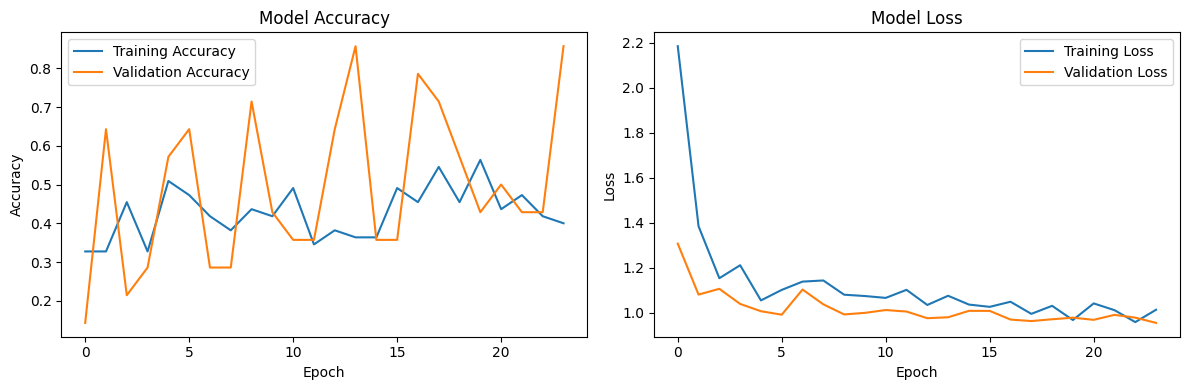

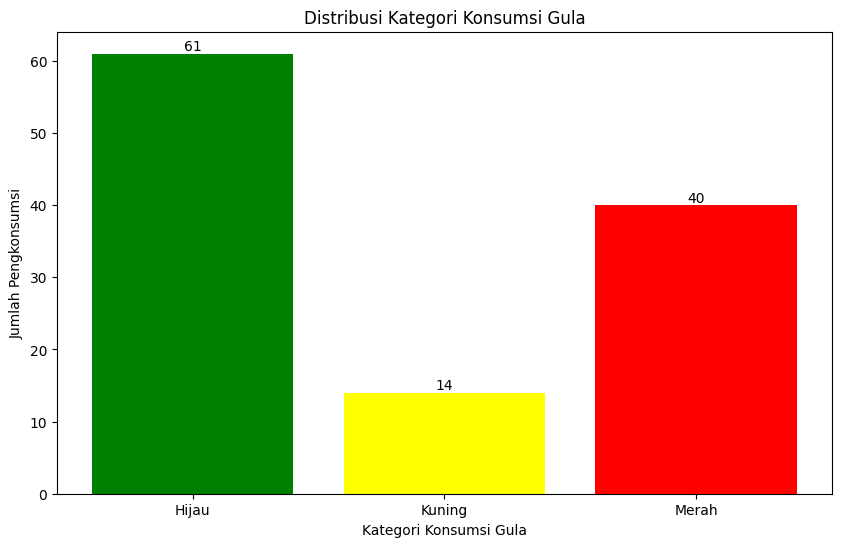

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

Konsumsi gula harian: 70g
Kategori: merah
Saran: Konsumsi gula harian berlebihan.


In [ ]:
if __name__ == "__main__":
    data = process_data("consume.csv")

    X = data[['Total_Sugar_g']].values
    y = data['consume_category']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    classifier = SugarConsumptionClassifier()
    classifier.fit(X_train, y_train, X_val, y_val)

    evaluation = classifier.evaluate(X_test, y_test)
    print("\nModel Evaluation:")
    print(f"Accuracy: {evaluation['accuracy']:.2%}")
    print("\nConfusion Matrix:")
    print(evaluation['confusion_matrix'])
    print("\nClassification Report:")
    print(evaluation['classification_report'])


    classifier.plot_training_history()
    plot_category_distribution(data)

    daily_sugar_intake = 70
    result = predict_sugar_category(classifier, daily_sugar_intake)
    print(f"\nKonsumsi gula harian: {daily_sugar_intake}g")
    print(f"Kategori: {result['category']}")
    print(f"Saran: {result['advice']}")